# Form Captcha with 4 Digits
The notebook code provides two basic funktions for 1. creating an image from a string (using PIL) and 2. creating a hash value (signature) based on that string plus a secret string and a timestamp. The created image will be shown on an input form to verify that a user is a human and not a bot. Hash value and creation time will added as hidden fields to the form. The hash value will be used to verify the input string. The creation time can be used to set a time limit for the input. All values will be stored in a log file to prevent that the form parameters are used repetitive.

## Functions

In [114]:
from PIL import Image, ImageDraw, ImageFont
import hashlib
import random
from datetime import datetime, timedelta
import json
import base64
from io import BytesIO

# GLOBAL CONSTANTS
secret_key='uiwe#sdfj$%sdfj'
life_time=600
font_path = "/usr/share/fonts/truetype/freefont/DejaVuSansMono-Bold.ttf"
log_path = "/tmp/captcha.log"

# HELPER FUNCTIONS
# [1] Create an image object from a given text of 4 digits
def create_image(text):
	# create an image with the given text
	image = Image.new("RGB", (100, 38), (0, 0, 0))
	# create a drawing object
	draw = ImageDraw.Draw(image)
	# set the font of the text
	font = ImageFont.truetype(font_path, 36)
	# draw the text on the image
	draw.text((5, -3), text, font=font, fill=(255, 255, 255))
	# draw.line((0,8, 100,30), fill=(0,0,0), width=3)
	# draw.line((0,30, 80,0), fill=(255,255,255), width=3)
	# create a BytesIO object
	buffered = BytesIO()
	# save image to the BytesIO object
	image.save(buffered, format="PNG")
	# get the value of the BytesIO object
	image_bytes = buffered.getvalue()
	image_str = base64.b64encode(image_bytes).decode("utf-8")
	# return data_uri
	return f"data:image/png;base64,{image_str}"


# [2] Create hash of a given string
def encrypt_password(pw, algorithm='sha256', hex=False):
	algorithm = algorithm.lower()
	enc = None
	if algorithm in list(hashlib.algorithms_available):
		h = hashlib.new(algorithm)
		h.update(pw.encode())
		if hex:
			enc = h.hexdigest()
		else:
			enc = h.digest()
	return enc

# [3] Write captcha data to a file
def write_captcha_data(captcha_str, file_path):
	was_used = False
	with open(file_path, 'r') as file_read:
		l = [line.strip() for line in file_read.readlines()]  # remove line breaks
		if captcha_str not in l:
			# add the new captcha to the list
			l.append(captcha_str)
			with open(file_path, 'w') as file_write:
				file_write.write('\n'.join(l))
		else:
			was_used = True
	if was_used: 
		# used before means it is not written to the file
		return False
	else: 
		# not used before means it is written to the file
		return True

# [4] Read captcha data from a file
def read_captcha_data(file_path):
	with open(file_path, 'r') as file:
		l = [int(line.strip()) for line in file.readlines()]  # remove line breaks
	# keep only the last 100 entries
	if len(l) > 100:
		l = l[-100:]
		with open(file_path, 'w') as file:
			file.write('\n'.join([str(i) for i in l]))
	return l

# [5] Exclude the logged list of numbers from a random number generator
def randint_exclude(start, end, exclude):
	while True:
		rand_num = random.randint(start, end)
		if rand_num not in exclude:
			return rand_num

# ##############################
# MAIN FUNCTIONS
# ##############################
# [A] Create Captcha with global constants:
#	@secret_key
#	@life_time
def captcha_create(secret_key='uiwe#sdfj$%sdfj', life_time=600):
	# Generate a random string that is not in the log file
	l = read_captcha_data(log_path)
	captcha_str = str(randint_exclude(1000, 9999, l))
	# Create a timestamp
	timestamp_create = int(datetime.timestamp(datetime.now()) * 1000)
	# Create a signature key from the secret key, captcha string and timestamp
	signature = encrypt_password(secret_key + captcha_str + str(timestamp_create), 'sha256', True)
	# Create captcha image as data-uri
	captcha_data_uri = create_image(captcha_str)

	# create a dictionary to store the captcha data
	captcha_dict = {
		'signature': signature,						# Used to validate the captcha
		'_captcha_str': captcha_str, 				# Private: to be entered by the user
		'timestamp_create': timestamp_create,		# Used to validate the lifetime
		'life_time': life_time, 					# Needed to refresh the captcha after this time
		'captcha_data_uri': captcha_data_uri 		# Used to display the captcha image
	}
	return captcha_dict

# [B] Validate Captcha:
#	@signature: the public key of the captcha
#	@secret_key: the secret key of the captcha
#	@captcha_str: the captcha string entered by the user
#	@timestamp_create: the timestamp when the captcha was created
#	@life_time: the life time of the captcha
def captcha_validate(signature, secret_key, captcha_str, timestamp_create, life_time):
	dt_create = datetime.utcfromtimestamp(float(timestamp_create) / 1e3)
	dt_receive = datetime.utcfromtimestamp((datetime.timestamp(datetime.now()) * 1000) / 1e3)
	is_intime = (dt_receive - dt_create).total_seconds() < life_time
	is_valid = signature == encrypt_password(secret_key + str(captcha_str) + str(timestamp_create), 'sha256', True)
	if is_intime and is_valid:
		# check if the captcha was used before
		if write_captcha_data(captcha_str, log_path):
			return True
		else:
			return False
	else:
		return False


## TEST: Create Captcha Image and Check Parameters

{
    "signature": "f3c5db47cf5d726692369d928729c92331da30027b747f3b41db586ffb6c25b0",
    "_captcha_str": "3896",
    "timestamp_create": 1711482562896,
    "life_time": 600,
    "captcha_data_uri": ""
}

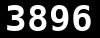

In [121]:
# Create a captcha
captcha_data = captcha_create(secret_key, life_time)
# Create a JSON object from the captcha_dict
captcha_data_json = json.dumps(captcha_data, indent=4)
# Send the captcha_data_json to the client
print(captcha_data_json)

# TEST: Validate Captcha Check Parameters

In [122]:
# Get the json data from the client request

req_data_json = """{
	"signature": "f3c5db47cf5d726692369d928729c92331da30027b747f3b41db586ffb6c25b0",
	"captcha_str": "3896",
	"timestamp_create": 1711482562896
}"""

req_data = json.loads(req_data_json)

# Validate the captcha
captcha_is_valid = captcha_validate(req_data.get('signature'), secret_key, req_data.get('captcha_str'), req_data.get('timestamp_create'), life_time)
print ('Captcha is valid:', captcha_is_valid)
print(read_captcha_data(log_path))

Captcha is valid: True
[1674, 6234, 9049, 4683, 9275, 3896]


In [106]:
# ##############################
# ZOPE-API-CALL captcha(create|validate)
# ##############################
def captcha_func(self, do):
	try:
		request = self.REQUEST
	except:
		request = {}
	if do == 'create':
		# Create a captcha
		captcha_data = captcha_create(secret_key, life_time)
		# Create a JSON object from the captcha_dict
		captcha_data_json = json.dumps(captcha_data, indent=4)
		# Send the captcha_data_json to the client
		return captcha_data_json
	elif do == 'validate':
		req_data = {}
		# Get the relevant captcha data from the client request
		for k in ['signature','captcha_str','timestamp_create']:
			req_data[k] = request.get(k,0)
		# Validate the captcha data
		captcha_is_valid = captcha_validate(req_data.get('signature'), secret_key, req_data.get('captcha_str'), req_data.get('timestamp_create'), life_time)
		return captcha_is_valid and json.dumps({'captcha_is_valid':True}) or json.dumps({'captcha_is_valid':False})


In [112]:
print(captcha_func(self={}, do='validate'))

{"captcha_is_valid": false}
